In [17]:
from pykml import parser
import geopandas as gpd
import shapely
import osmnx as ox
import osmnx.distance
import pyproj

with open("wandrer-23-08-23.kml", "r") as f:
    root = parser.parse(f).getroot()

namespace = {"kml": 'http://www.opengis.net/kml/2.2'}
pms = root.xpath(".//kml:Placemark[.//kml:Polygon]", namespaces=namespace)
# for p in pms:
#   print(p.Polygon.outerBoundaryIs.LinearRing.coordinates)
print(pms[0])

In [18]:
len(root.xpath(".//kml:Placemark[.//kml:LineString]", namespaces=namespace))

89530

In [19]:
root.getchildren()[0].countchildren()

89658

In [20]:
# Get ready
linestrings = root.xpath(".//kml:Placemark[.//kml:LineString]", namespaces=namespace)
crs = "WGS84"
geod = pyproj.Geod(ellps=crs)
linestrings = [ls for ls in linestrings if hasattr(ls, "LineString")]
# Use this dictionary method so an error is thrown if there's some key I haven't seen at the time of programming
travel_tags = {"#Traveled": True, "#TraveledUnpaved": True, "#Untraveled": False, "#UntraveledUnpaved": False}
linestrings_traveled = [travel_tags[ls.styleUrl] for ls in linestrings]
linestring_coordinate_texts = [ls.LineString.coordinates.text for ls in linestrings if hasattr(ls, "LineString")]
linestring_coords = [[tuple([float(c) for c in p.split(",")[:2]]) for p in ls.split(" ")] for ls in linestring_coordinate_texts]

In [21]:
# Go!
nodes = {}
node_counter = 0
edge_counts = {}
edge_lengths = {}
edges = []

# Count up IDs for nodes and edges
for coords, traveled in zip(linestring_coords, linestrings_traveled):
    first, last = coords[0], coords[-1]
    for coord in (first, last):
        if coord not in nodes:
            nodes[coord] = node_counter
            node_counter += 1
    first_id, last_id = nodes[first], nodes[last]
    edge_count = edge_counts.get((first_id, last_id), 0)
    length = sum(geod.inv(*first, *second, radians=False)[2] for first, second in zip(coords[:-1], coords[1:]))
    edges.append((first_id, last_id, edge_count, length, traveled, shapely.LineString(coords)))
    edge_counts[(first_id, last_id)] = edge_count + 1

graph_nodes = gpd.GeoDataFrame([(value, key[0], key[1]) for key, value in nodes.items()], columns=["osmid", "x", "y"])
graph_nodes.set_index(["osmid"], inplace=True) # We fake the OSMID, but it still needs to be the key
graph_edges = gpd.GeoDataFrame(edges, columns=["u", "v", "key", "length", "traveled", "geometry"], crs=crs)
graph_edges.set_index(["u", "v", "key"], inplace=True)
del nodes
del edges
del edge_counts
# graph_nodes.loc[node_counter] = [first[0], first[1]]
# graph_edges.loc[(first_id, last_id, edge_count)] = [shapely.geometry.LineString(coords)]
# Free up those wonderful helper hashsets
# del edge_counts
# del nodes

In [22]:
graph = ox.graph_from_gdfs(graph_nodes, graph_edges)

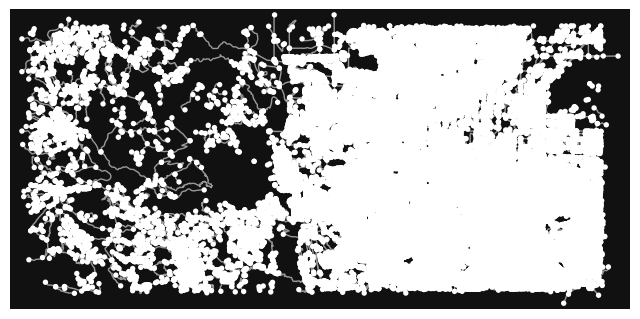

In [23]:
# preview the graph
fig, ax = ox.plot_graph(graph)

In [24]:
list(graph.edges(data=True))[:100]

[(0,
  1,
  {'length': 388.53700986618435,
   'traveled': False,
   'geometry': <LINESTRING (-105.543 39.895, -105.543 39.895, -105.543 39.894, -105.544 39....>}),
 (2,
  0,
  {'length': 268.5023129967009,
   'traveled': False,
   'geometry': <LINESTRING (-105.542 39.897, -105.543 39.896, -105.543 39.895)>}),
 (3,
  0,
  {'length': 419.9631224099079,
   'traveled': False,
   'geometry': <LINESTRING (-105.547 39.893, -105.547 39.893, -105.546 39.893, -105.545 39....>}),
 (4,
  5,
  {'length': 638.0555073204077,
   'traveled': False,
   'geometry': <LINESTRING (-105.548 39.877, -105.547 39.877, -105.547 39.877, -105.547 39....>}),
 (5,
  10,
  {'length': 280.77027718317714,
   'traveled': False,
   'geometry': <LINESTRING (-105.541 39.879, -105.54 39.879, -105.54 39.879, -105.539 39.88...>}),
 (6,
  7,
  {'length': 3825.3194781669145,
   'traveled': False,
   'geometry': <LINESTRING (-105.557 39.887, -105.557 39.887, -105.557 39.887, -105.556 39....>}),
 (8,
  9,
  {'length': 787.6024911

In [25]:
graph.edges((10, 11, 0), data=True)

OutMultiEdgeDataView([(10, 11, {'length': 334.85476936536395, 'traveled': False, 'geometry': <LINESTRING (-105.539 39.88, -105.538 39.881, -105.538 39.881, -105.538 39.8...>}), (0, 1, {'length': 388.53700986618435, 'traveled': False, 'geometry': <LINESTRING (-105.543 39.895, -105.543 39.895, -105.543 39.894, -105.544 39....>})])

In [26]:
graph.nodes[0]

{'x': -105.543208, 'y': 39.89479}

In [29]:
graph_nodes

,x,y
osmid,,
0,-105.543208,39.894790
1,-105.543830,39.891522
2,-105.542103,39.897053
3,-105.546792,39.892608
4,-105.547682,39.876876
...,...,...
69118,-104.938885,39.855383
69119,-104.938381,39.856849
69120,-104.938853,39.854798
